In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
from zoneinfo import ZoneInfo
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.rcParams.update({'font.size': 14})

# Analysing Data

First read both datasets and look if timestamps or values of features are missing.

In [165]:
# import dataset
df_train = pd.read_csv('data/train.csv', delimiter=',', decimal='.')

df_train['time'] = pd.to_datetime(df_train['time'], errors='coerce', utc=True).map(lambda x: x.tz_convert('Europe/Tallinn'))

df_train.set_index('time', inplace=True)
df_train = df_train.asfreq('h')

df_train.info() # all columns are full except snow and demand

# summer / winter time change isn't a problem, because timezone info is included

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8424 entries, 2021-09-01 00:00:00+03:00 to 2022-08-17 23:00:00+03:00
Freq: h
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    8424 non-null   float64
 1   dwpt    8424 non-null   float64
 2   rhum    8424 non-null   float64
 3   snow    119 non-null    float64
 4   wdir    8424 non-null   float64
 5   wspd    8424 non-null   float64
 6   wpgt    8424 non-null   float64
 7   pres    8424 non-null   float64
 8   price   8424 non-null   float64
 9   demand  8338 non-null   float64
dtypes: float64(10)
memory usage: 723.9 KB


In [166]:
# import dataset
df_test = pd.read_csv('data/test.csv', delimiter=',', decimal='.')

df_test['time'] = pd.to_datetime(df_test['time'], errors='coerce', utc=True).map(lambda x: x.tz_convert('Europe/Tallinn'))

df_test.set_index('time', inplace=True)
df_test = df_test.asfreq('h')

df_test.info() # all columns are full except snow

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2022-08-18 00:00:00+03:00 to 2022-08-24 23:00:00+03:00
Freq: h
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    168 non-null    float64
 1   dwpt    168 non-null    float64
 2   rhum    168 non-null    float64
 3   snow    0 non-null      float64
 4   wdir    168 non-null    float64
 5   wspd    168 non-null    float64
 6   wpgt    168 non-null    float64
 7   pres    168 non-null    float64
 8   price   168 non-null    float64
 9   demand  168 non-null    float64
dtypes: float64(10)
memory usage: 14.4 KB


## Clean Data

Snow has a lot of missing values and demand has a few ones, both are analysed on how there occurence (or them missing) could be influences through other features (e.g. by looking at the mean)

Summer/winter time is not a problem, because TZ is included so they are continous timestamps with 1 hour differences

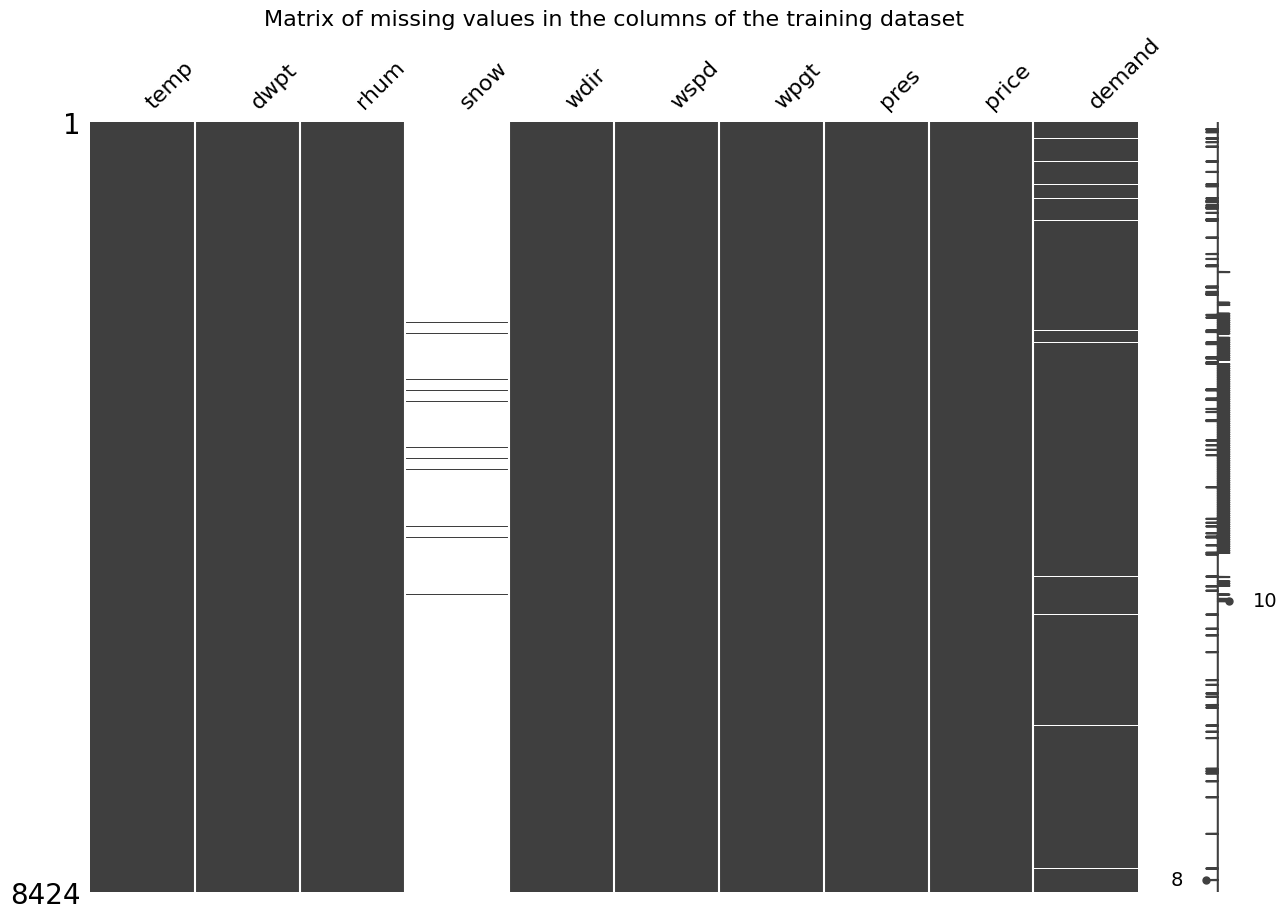

In [167]:
import missingno as msno

#overview of missing values
msno.matrix(df_train, figsize=(15,10))
plt.title("Matrix of missing values in the columns of the training dataset", fontsize=16)
plt.savefig("diagrams/matrix_missing_values.pdf")

In [168]:
no_demand = df_train[df_train['demand'].isnull()]

print(no_demand.mean())
print(df_train.mean())

# looks like missing at random (no abhängigkeiten)

temp         5.390698
dwpt         1.132558
rhum        76.976744
snow       200.000000
wdir       201.860465
wspd         9.104651
wpgt        20.216279
pres      1015.467442
price        0.158745
demand            NaN
dtype: float64
temp         6.435708
dwpt         2.228359
rhum        77.191121
snow        78.319328
wdir       202.886633
wspd         9.132918
wpgt        20.931588
pres      1013.128063
price        0.156541
demand       1.055267
dtype: float64


In [169]:
snow = df_train[df_train['snow'].notnull()]

print("Max temperature: ", snow['temp'].max())
print(df_train['snow'].describe())

print(snow.mean())
print(df_train.mean())

# missing a lot of values, especially if it was zero -> delete column (not needed)

Max temperature:  3.9
count    119.000000
mean      78.319328
std       63.129130
min        0.000000
25%       20.000000
50%       60.000000
75%      130.000000
max      220.000000
Name: snow, dtype: float64
temp        -3.273950
dwpt        -5.026050
rhum        88.033613
snow        78.319328
wdir       208.571429
wspd         9.166387
wpgt        20.684034
pres      1008.713445
price        0.196023
demand       1.018686
dtype: float64
temp         6.435708
dwpt         2.228359
rhum        77.191121
snow        78.319328
wdir       202.886633
wspd         9.132918
wpgt        20.931588
pres      1013.128063
price        0.156541
demand       1.055267
dtype: float64


In [170]:
# demand is filled with mean and snow column is dropped because it doesn't have many values

df_train['demand'].fillna(df_train['demand'].mean(), inplace=True)
df_train = df_train.drop(columns=['snow'])

df_train.info() #  now it is complete -> nothing is missing

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8424 entries, 2021-09-01 00:00:00+03:00 to 2022-08-17 23:00:00+03:00
Freq: h
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    8424 non-null   float64
 1   dwpt    8424 non-null   float64
 2   rhum    8424 non-null   float64
 3   wdir    8424 non-null   float64
 4   wspd    8424 non-null   float64
 5   wpgt    8424 non-null   float64
 6   pres    8424 non-null   float64
 7   price   8424 non-null   float64
 8   demand  8424 non-null   float64
dtypes: float64(9)
memory usage: 658.1 KB


/tmp/ipykernel_3920/870739390.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['demand'].fillna(df_train['demand'].mean(), inplace=True)


Make some statistics of data to get understanding of it.

Text(0, 0.5, 'Price [€]')

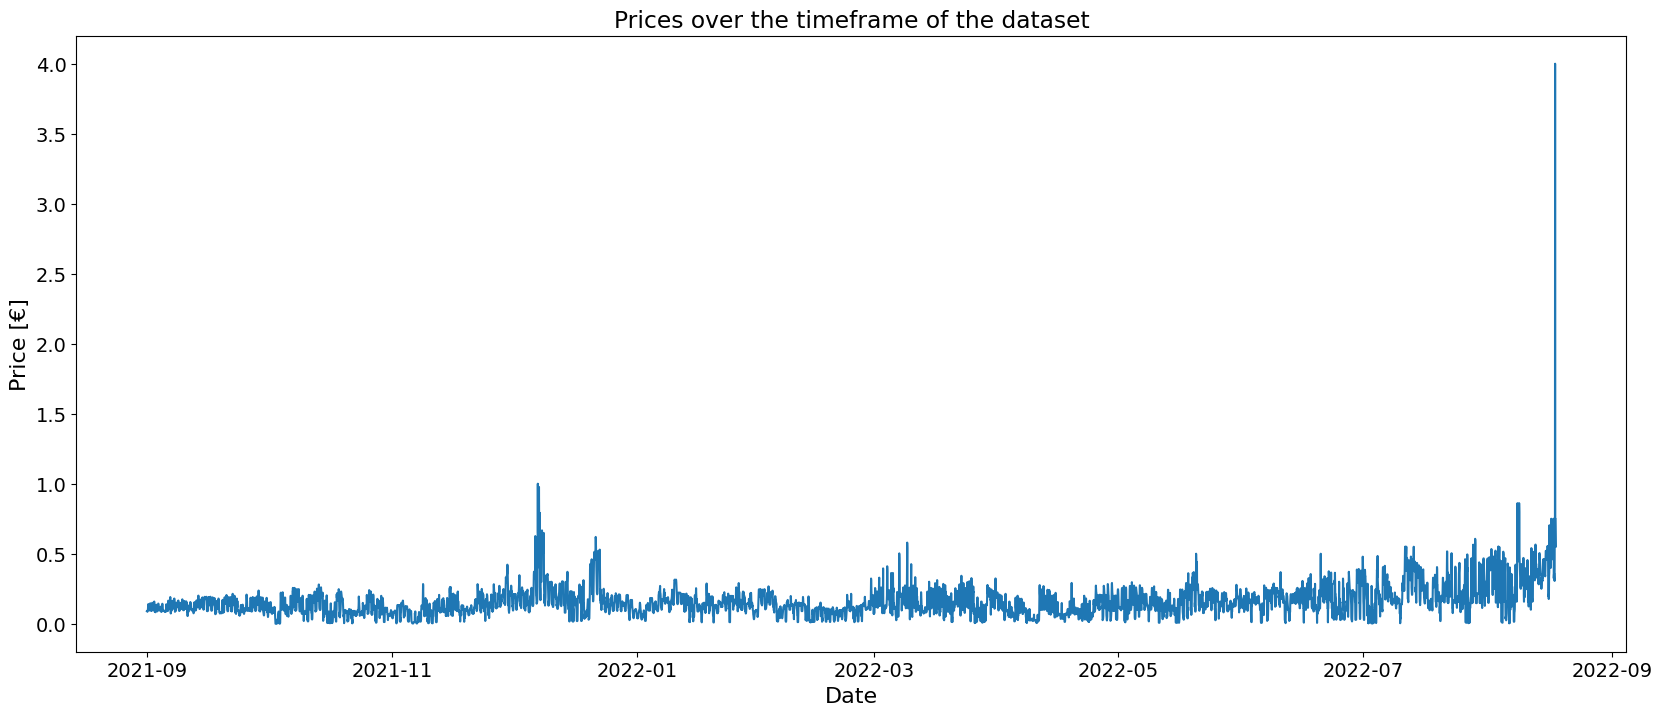

In [171]:
# plot prices
plt.figure(figsize=(20,8))
plt.title("Prices over the timeframe of the dataset")
p = sns.lineplot(data=df_train['price'])
p.set_xlabel("Date", fontsize=16)
p.set_ylabel("Price [€]", fontsize=16)

Text(203.84722222222223, 0.5, 'Demand [kWh]')

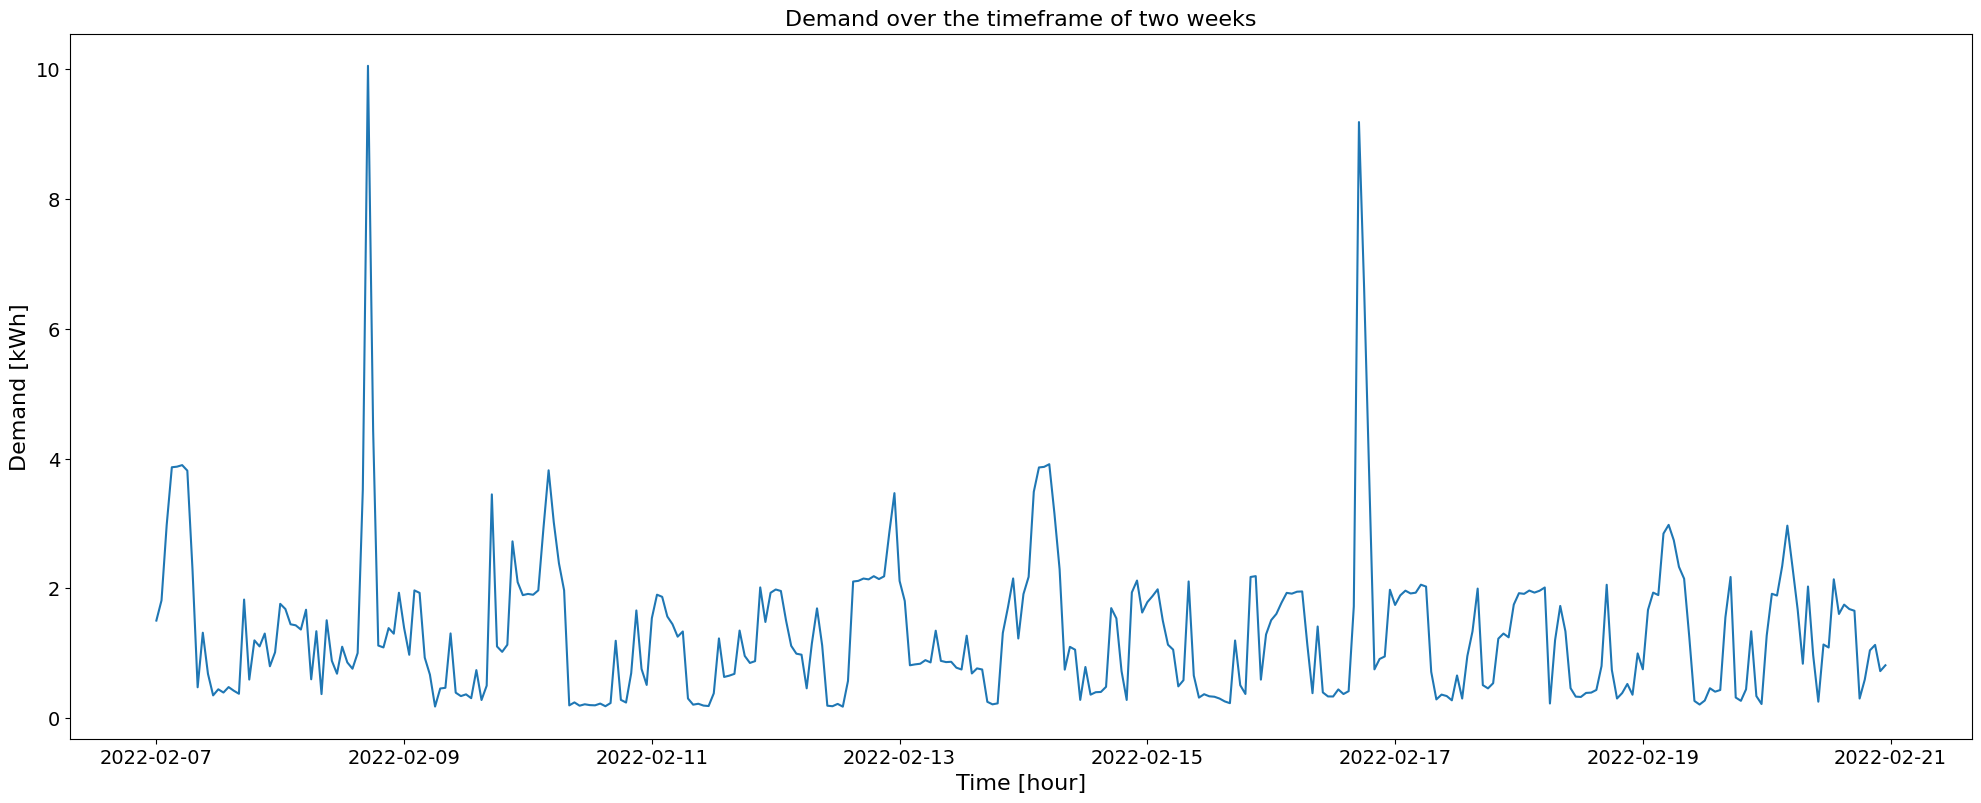

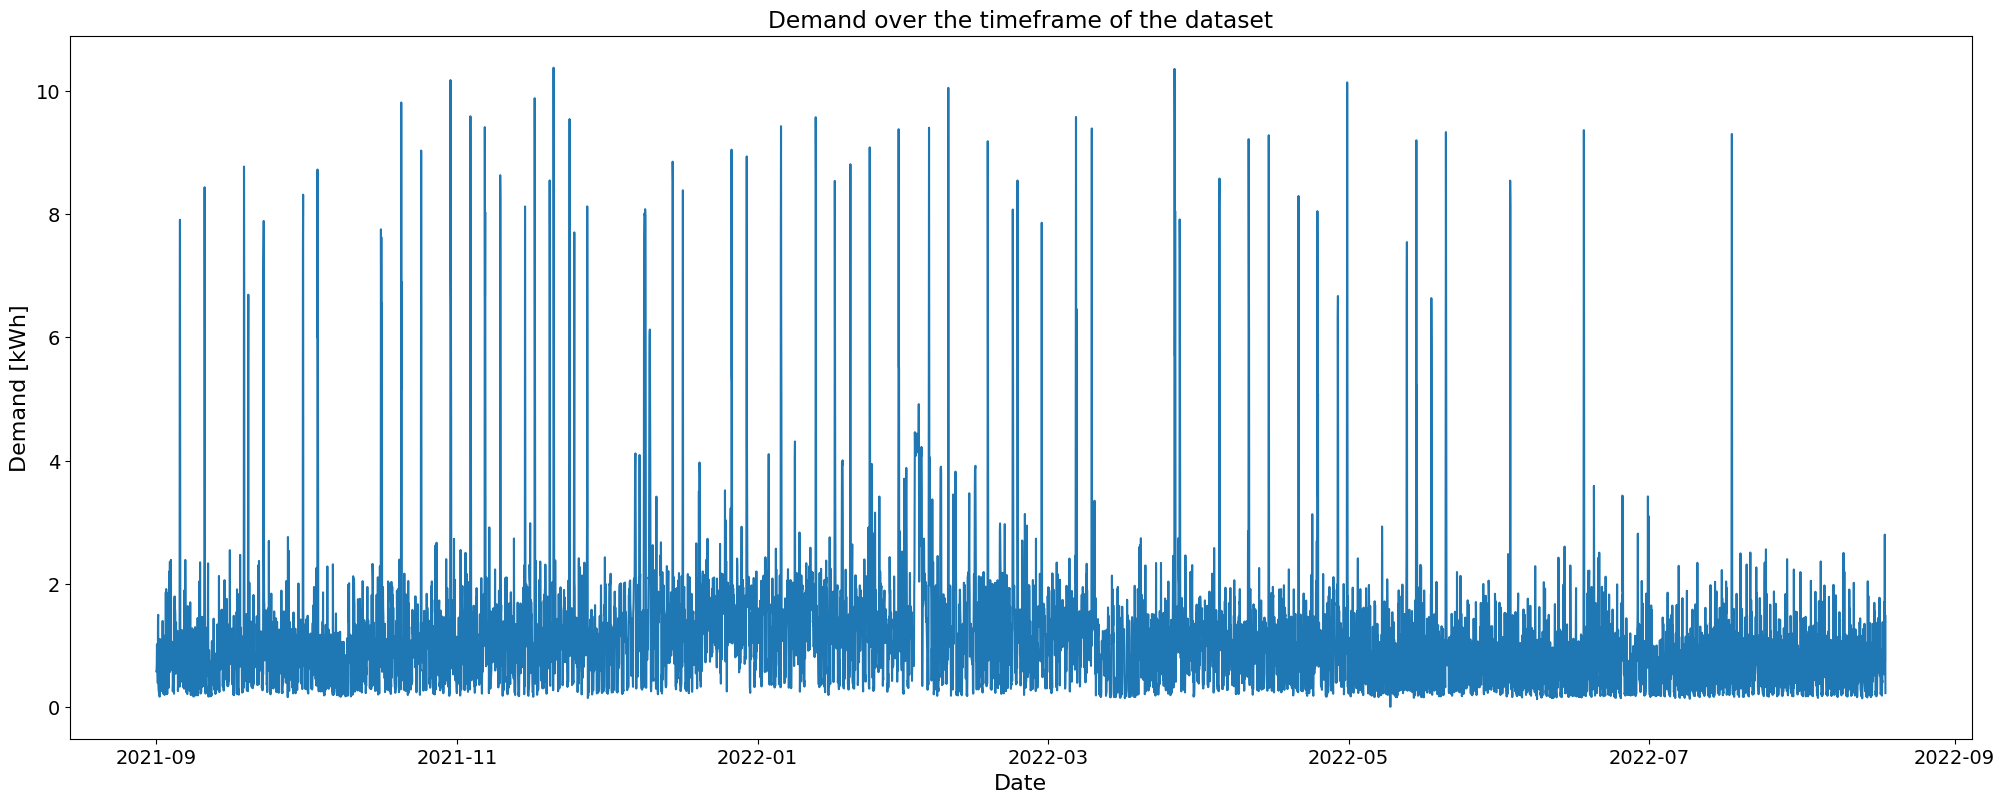

In [172]:
# check demand over two weeks and over whole time
start_date = datetime(2022, 2,7, tzinfo=ZoneInfo("Europe/Tallinn"))
end_date = datetime(2022, 2, 21, tzinfo=ZoneInfo("Europe/Tallinn"))

df_week = df_train[(df_train.index >= start_date) & (df_train.index < end_date)]

plt.figure(figsize=(20,8))
plt.title("Demand over the timeframe of two weeks", fontsize=16)
plt.tight_layout()
p = sns.lineplot(data=df_week['demand'])
p.set_xlabel("Time [hour]", fontsize=16)
p.set_ylabel("Demand [kWh]", fontsize=16)
plt.savefig("diagrams/demand_week.pdf")

plt.figure(figsize=(20,8))
plt.title("Demand over the timeframe of the dataset")
plt.tight_layout()
p = sns.lineplot(data=df_train['demand'])
p.set_xlabel("Date", fontsize=16)
p.set_ylabel("Demand [kWh]", fontsize=16)



In [173]:
# labels for diagrams
labels = {'temp': 'Air Temperature [°C]',
        'dwpt': 'Dew Point [°C]',
        'rhum': 'Relative Humidity [%]',
        'wdir': 'Wind Direction [°]',
        'wspd': 'Average Wind Speed [km/h]',
        'wpgt': 'Peak Wind Gust [km/h]',
        'pres': 'Sea-level Air Pressure [hPa]',
        'price': 'Estonian Electricity Price [€/kWh]',
        'demand': 'Electricity Demand [kWh]' }

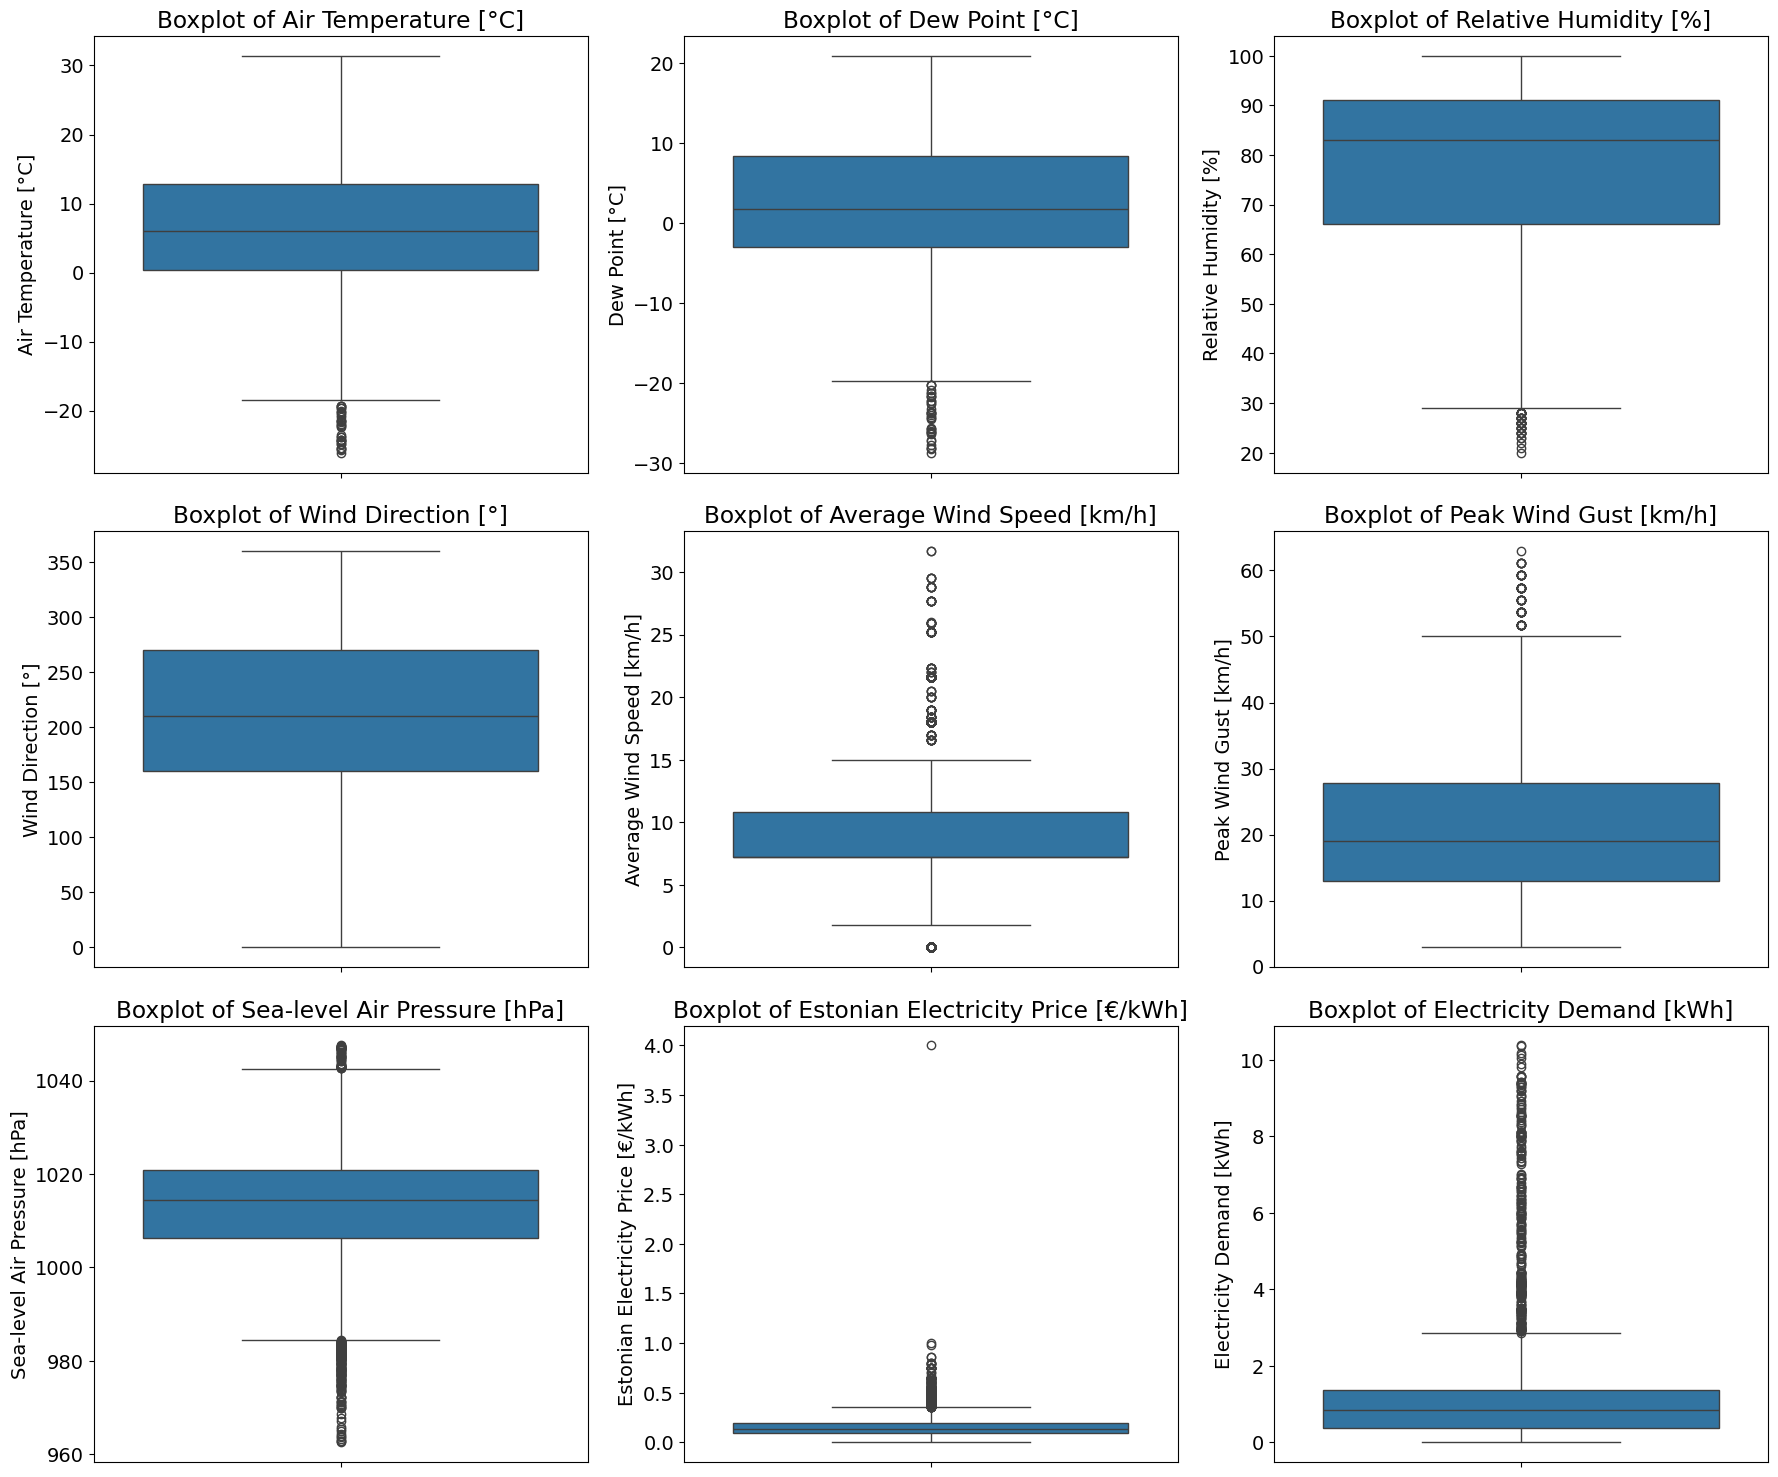

In [174]:
# plot boxplot of each feature
ncols = 3
nrows = math.ceil(len(df_train.columns) / ncols) # calculate num rows dynamically

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows))
axes = axes.flatten()

# plot each subgraph
for i, col in enumerate(df_train.columns):
    sns.boxplot(data=df_train, y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {labels[col]}')
    axes[i].set_ylabel(labels[col])

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("diagrams/boxplots_data.pdf")

All features have many outliers but the prices have one big one. That one needs to be removed and replaced. It will be replaced with the mean of the previous and next value.

In [176]:
# replace outlier with mean of previous and next price
max_ts = df_train['price'].idxmax()
max_idx = df_train.index.get_loc(max_ts)
df_train['price'][max_idx] = (df_train['price'][max_idx-1]+ df_train['price'][max_idx+1])/2
df_train['price'][max_idx]

/tmp/ipykernel_3920/3244307005.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_train['price'][max_idx] = (df_train['price'][max_idx-1]+ df_train['price'][max_idx+1])/2
/tmp/ipykernel_3920/3244307005.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a 

0.65005

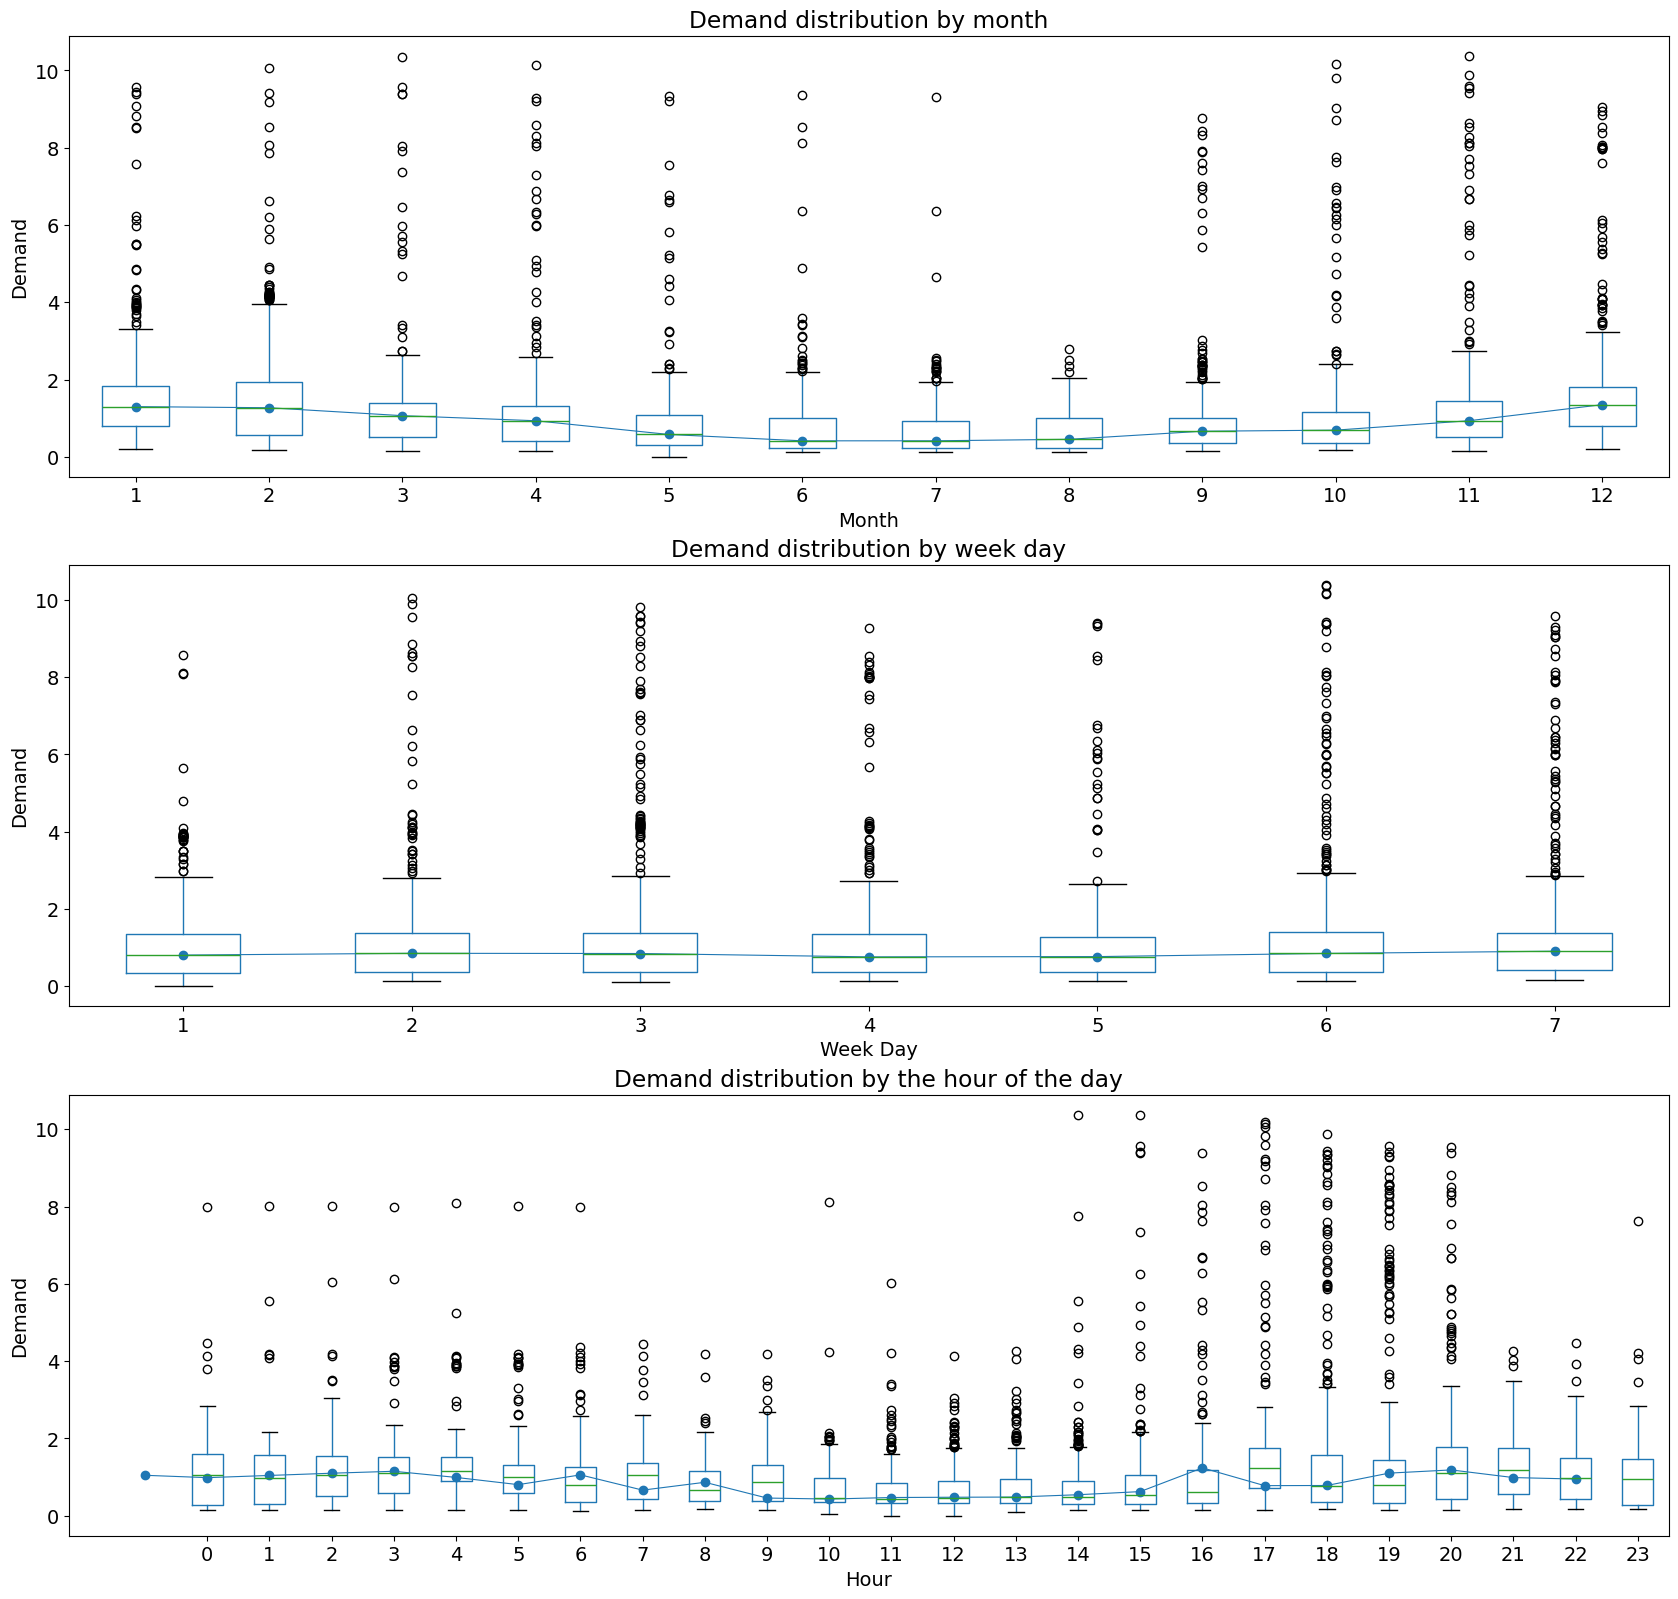

In [177]:
# get understanding of the times influence on the demand by looking at distributions by hour, weekday and month

data = df_train.copy()
fig, ax = plt.subplots(nrows=3, figsize=(20, 20))

# Demand distribution by month
# ==============================================================================

data['month'] = data.index.month
data.boxplot(column='demand', by='month', ax=ax[0],)
data.groupby('month')['demand'].median().plot(style='o-', linewidth=0.8, ax=ax[0])
ax[0].set_ylabel('Demand')
ax[0].set_xlabel('Month')
ax[0].set_title('Demand distribution by month')
fig.suptitle('')



# Demand distribution by week day
# ==============================================================================

data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='demand', by='week_day', ax=ax[1])
data.groupby('week_day')['demand'].median().plot(style='o-', linewidth=0.8, ax=ax[1])
ax[1].set_ylabel('Demand')
ax[1].set_xlabel('Week Day')
ax[1].set_title('Demand distribution by week day')
fig.suptitle('')

# Demand distribution by the hour of the day
# ==============================================================================

data['hour_day'] = data.index.hour 
data.boxplot(column='demand', by='hour_day', ax=ax[2])
data.groupby('hour_day')['demand'].median().plot(style='o-', linewidth=0.8, ax=ax[2])
ax[2].set_ylabel('Demand')
ax[2].set_xlabel('Hour')
ax[2].set_title('Demand distribution by the hour of the day')
fig.suptitle('')

plt.savefig("diagrams/boxplots_demand.pdf") #save them in one plot

## Analyze distribution of each variable

Build historgrams and look for normalized distribution.

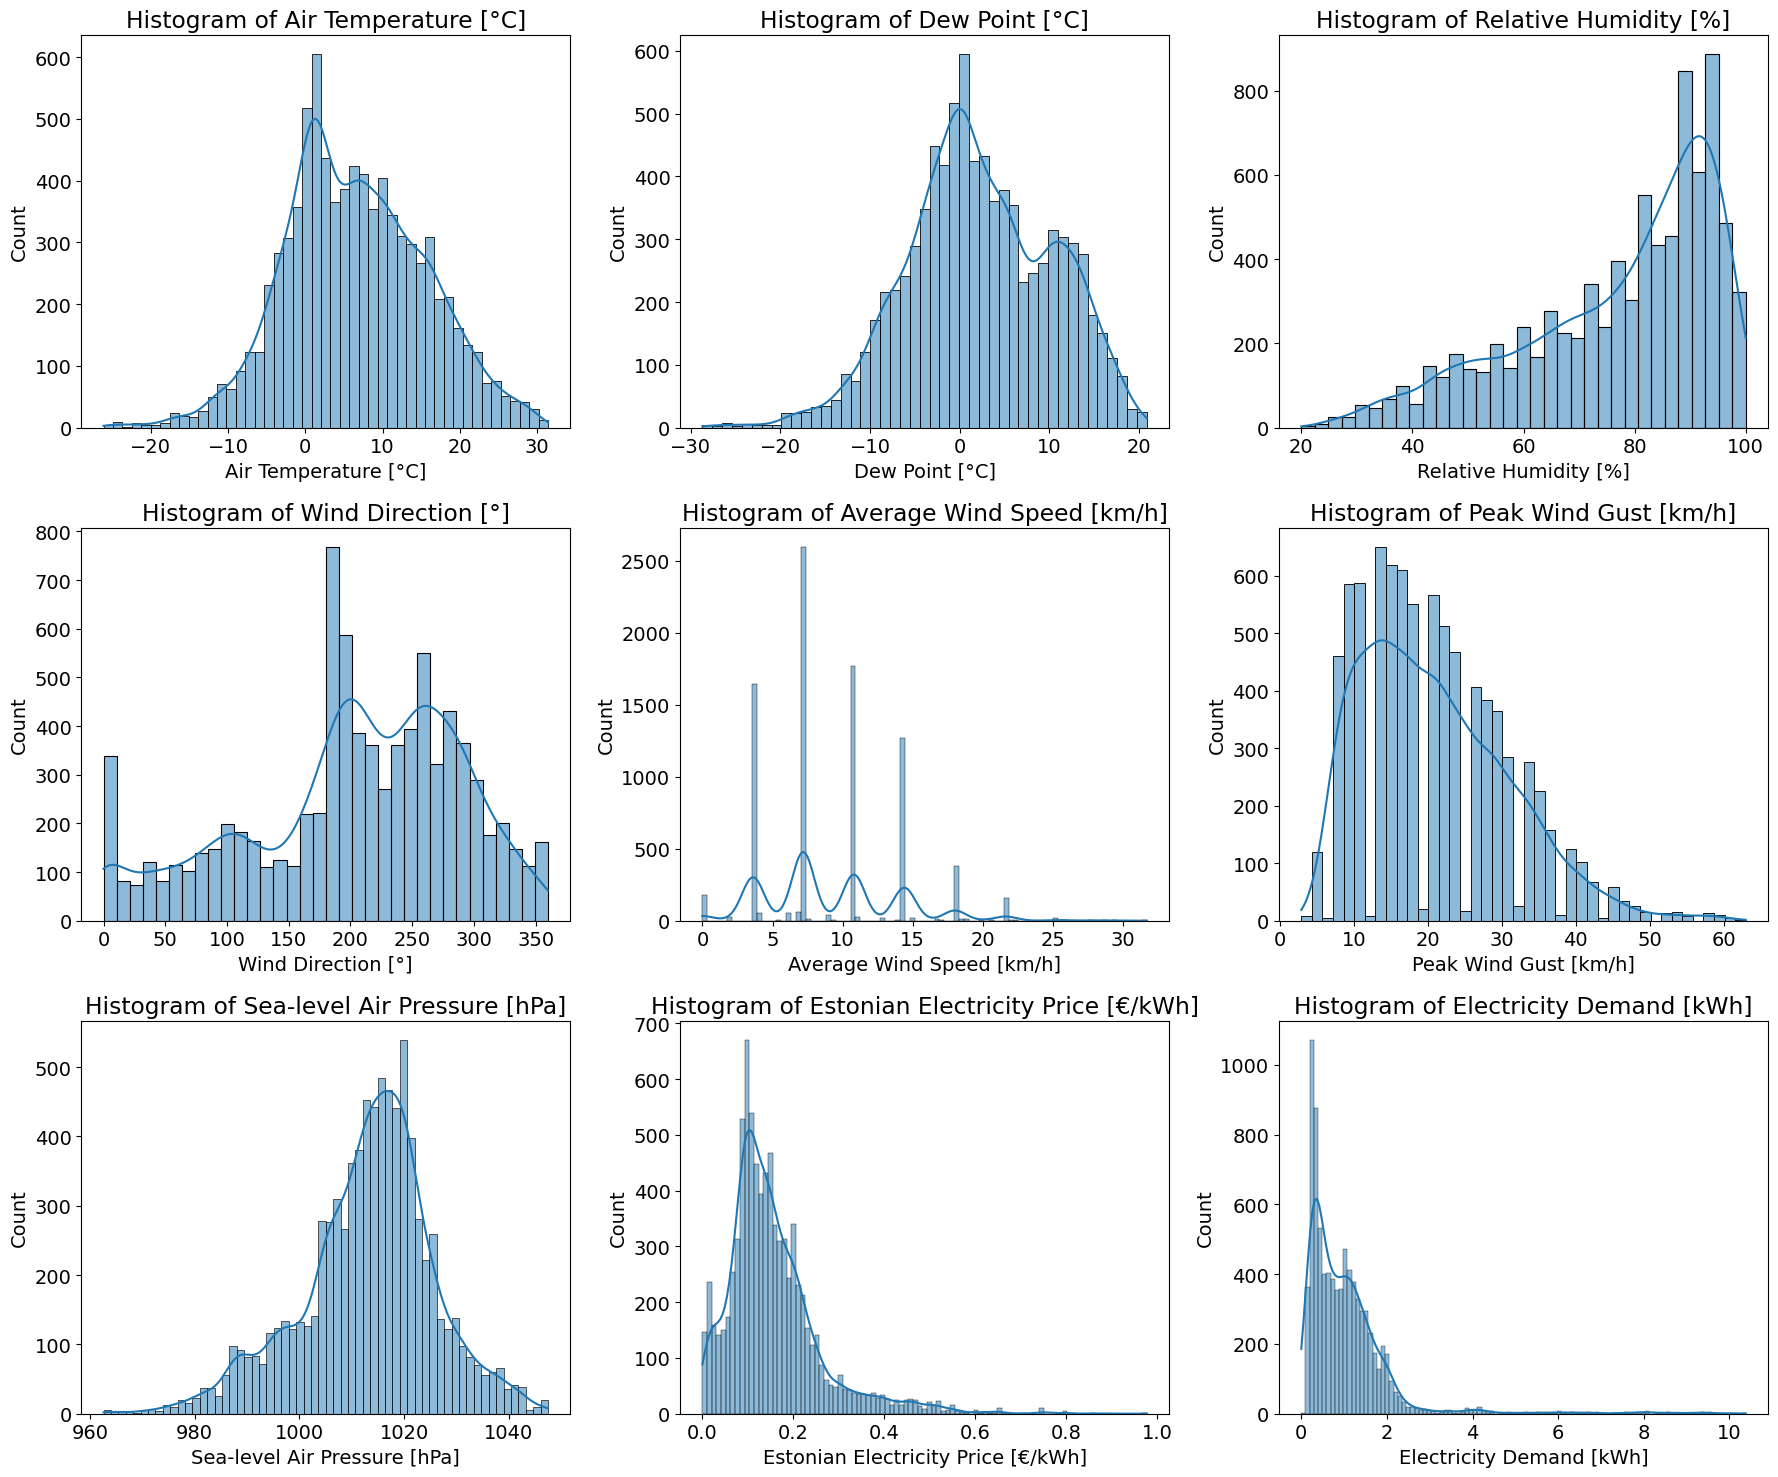

In [178]:
# plot boxplot of each feature
ncols = 3
nrows = math.ceil(len(df_train.columns) / ncols) # calculate num rows dynamically

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows))
axes = axes.flatten()

# plot each subgraph
for i, col in enumerate(df_train.columns):
    sns.histplot(data=df_train, x=col, ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram of {labels[col]}')
    axes[i].set_xlabel(labels[col])

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("diagrams/hist_before.pdf")

In [180]:
# make some example transformations

df_standard = df_train.copy()

# left-skewd
df_standard['rhum'] = np.power(df_standard['rhum'].max() - df_standard['rhum'], 1/3)

# right-skewd
df_standard['wpgt'] = np.power(df_standard['wpgt'], 1/2)
df_standard['wspd'] = np.power(df_standard['wspd'], 1/2)
df_standard['price'] = np.power(df_standard['price'], 1/3)

# wind direction is more complicated
df_standard['wdir'] = np.power(df_standard['wdir'], 1/2)
df_standard['wdir'] = np.power(df_standard['wdir'].max() - df_standard['wdir'], 1/2)

# normalization -> done if needed later
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#df_standard = train_multi_sc = pd.DataFrame(scaler.fit_transform(df_standard), columns=df_standard.columns, index=df_standard.index)

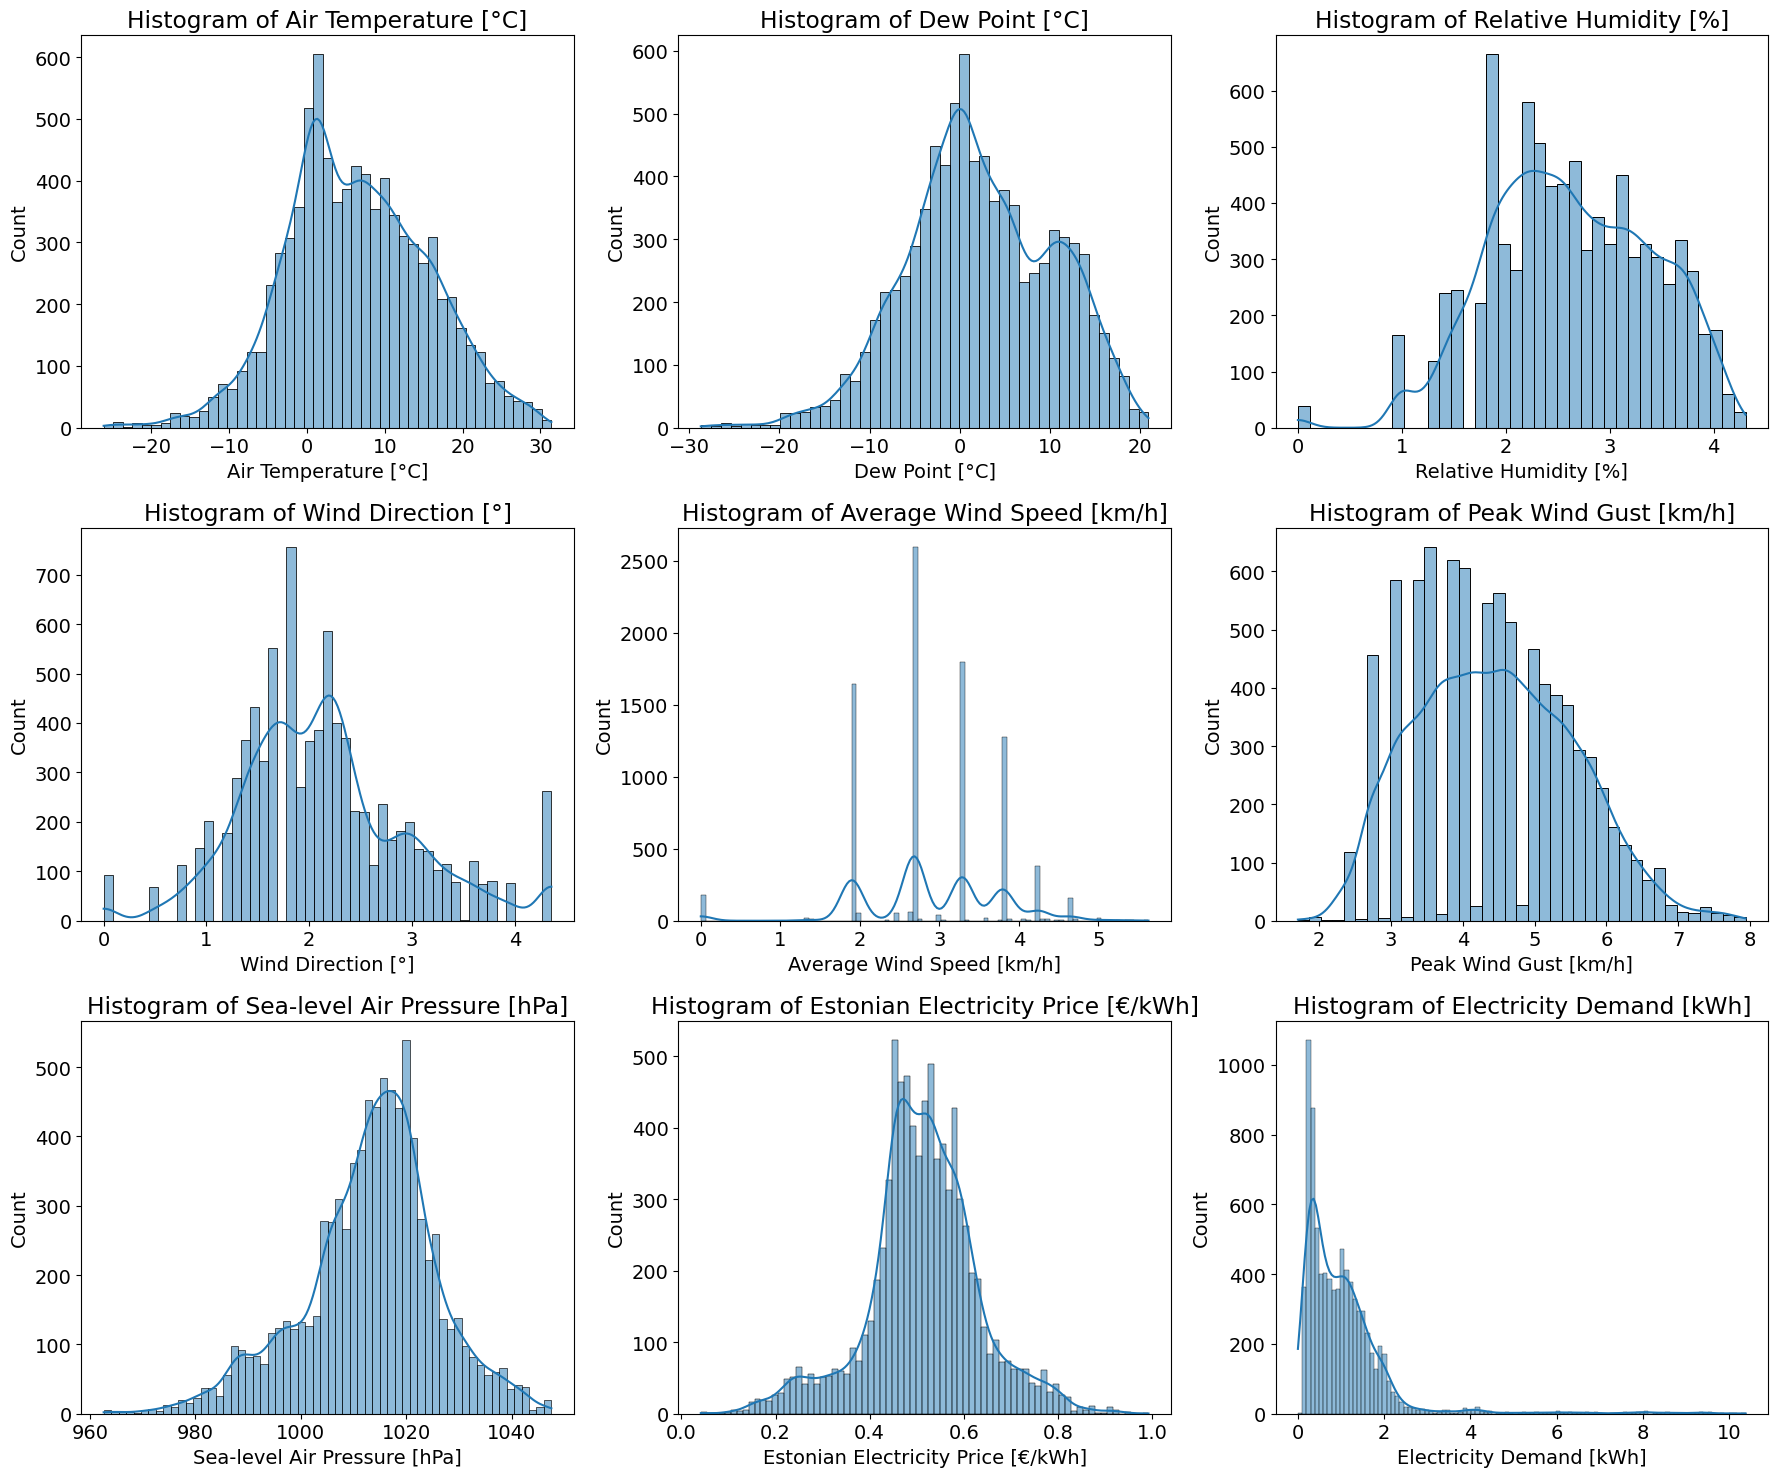

In [181]:
# plot boxplot of each feature
ncols = 3
nrows = math.ceil(len(df_standard.columns) / ncols)  # calculate num rows dynamically

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows))

axes = axes.flatten()

# plot each subgraph
for i, col in enumerate(df_standard.columns):
    sns.histplot(data=df_standard, x=col, ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram of {labels[col]}')
    axes[i].set_xlabel(labels[col])

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("diagrams/hist_after.pdf")

## New feature

Create new feature: hour -> has probably a little bit of influence on the demand (e.g. during night demand might be lower)

In [182]:
# here we are creating a new feature
df_train['hour'] = df_train.index.hour
df_standard['hour'] = df_standard.index.hour
df_test['hour'] = df_test.index.hour

## Ranking of features

By calculating the mutual information score; Ranking is the decending order of scores

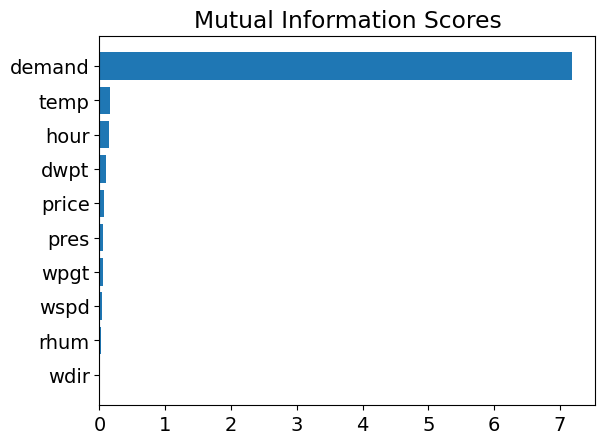

In [183]:
discrete_features = df_standard.dtypes == int

mi_scores = mutual_info_regression(df_standard, df_standard['demand'], discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=df_standard.columns)
mi_scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
plt.savefig("diagrams/mis.pdf")


# Modelling

Goal: build a model to predict the demand

## Autoregressive model

First check if data is stationary and if not make it stationary


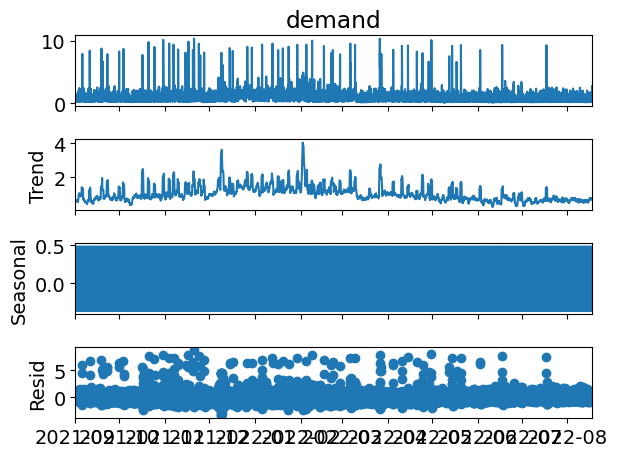

In [184]:
decompose = seasonal_decompose(df_train['demand'],model='additive',period=24)
decompose.plot()
plt.tight_layout()
plt.show() # seasonal decomposition doesn't really show a trend but small daily seasonal component

In [118]:
# do adfuller test additionally -> classifies data as stationary (or weak stationary)
fuller = adfuller(df_train['demand'])
print('ADF Statistic: %f' % fuller[0])
print('p-value: %f' % fuller[1])
print('Critical Values:')
for key, value in fuller[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.369470
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Demand over time is stationary (null hypothesis is rejected). 

Next ACF and PACF are created and analysed

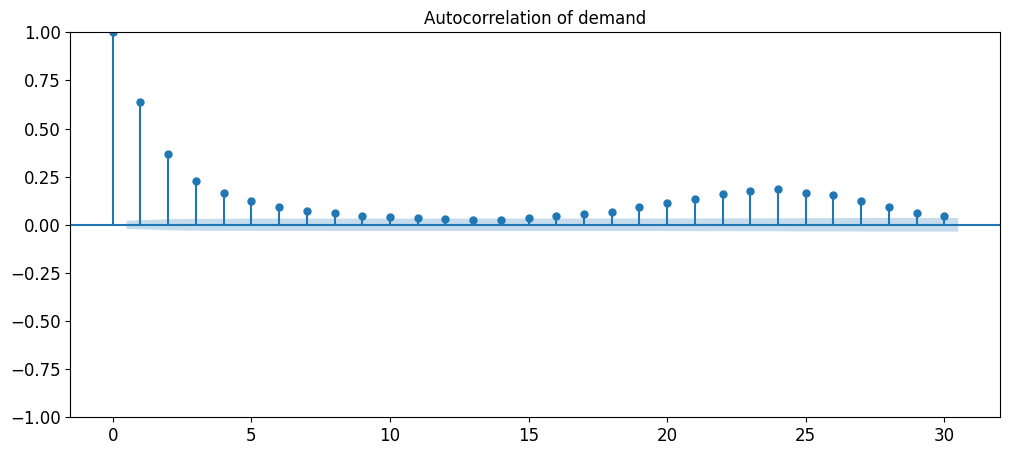

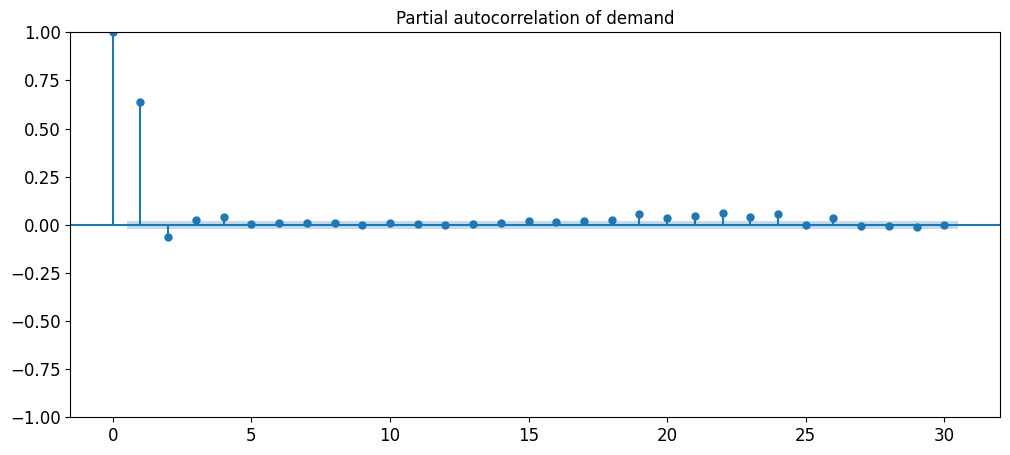

In [187]:
# ACF -> shows a small seasonal correlation
fig = plot_acf(df_train['demand'], lags=30)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title ('Autocorrelation of demand', fontsize=12)
fig.set_size_inches((12, 5))
plt.savefig("diagrams/acf.pdf")

# PACF
fig = plot_pacf(df_train['demand'], lags=30)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Partial autocorrelation of demand', fontsize=12)
fig.set_size_inches((12, 5))
plt.savefig("diagrams/pacf.pdf")

Also look at the seasonal difference of the data

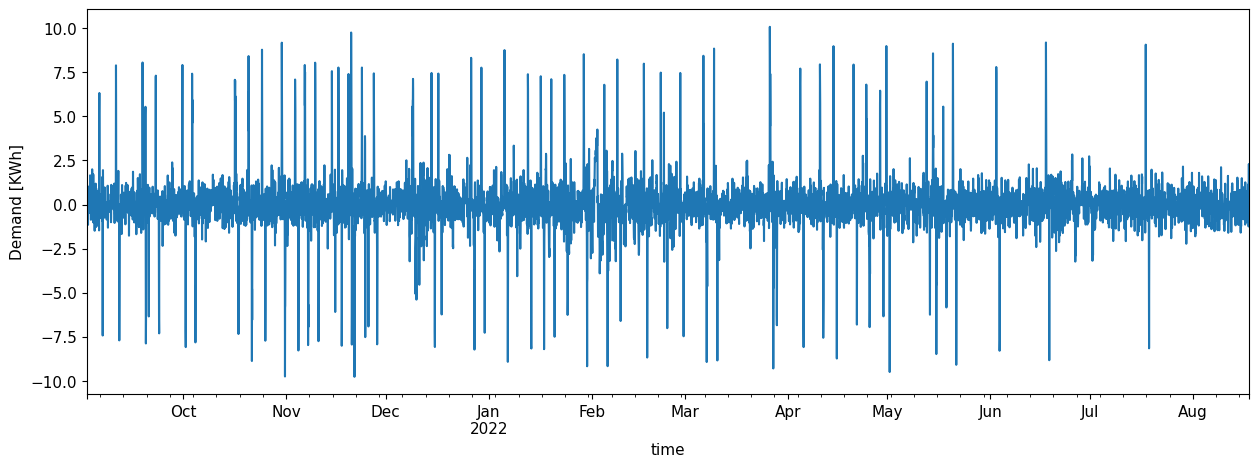

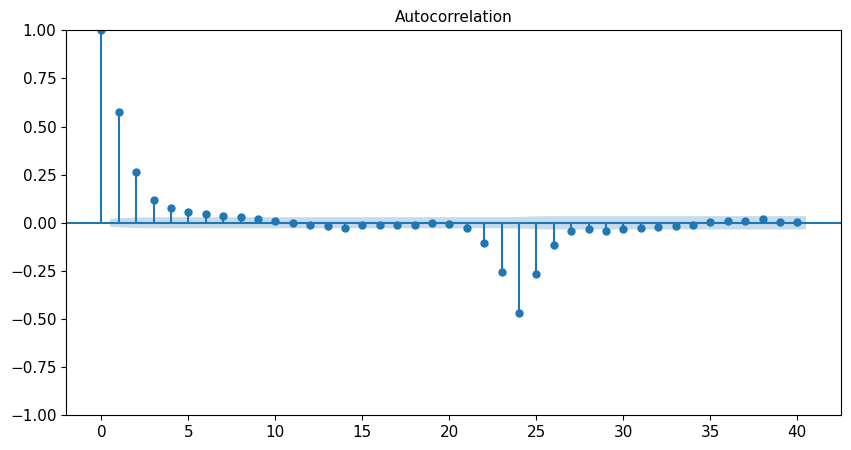

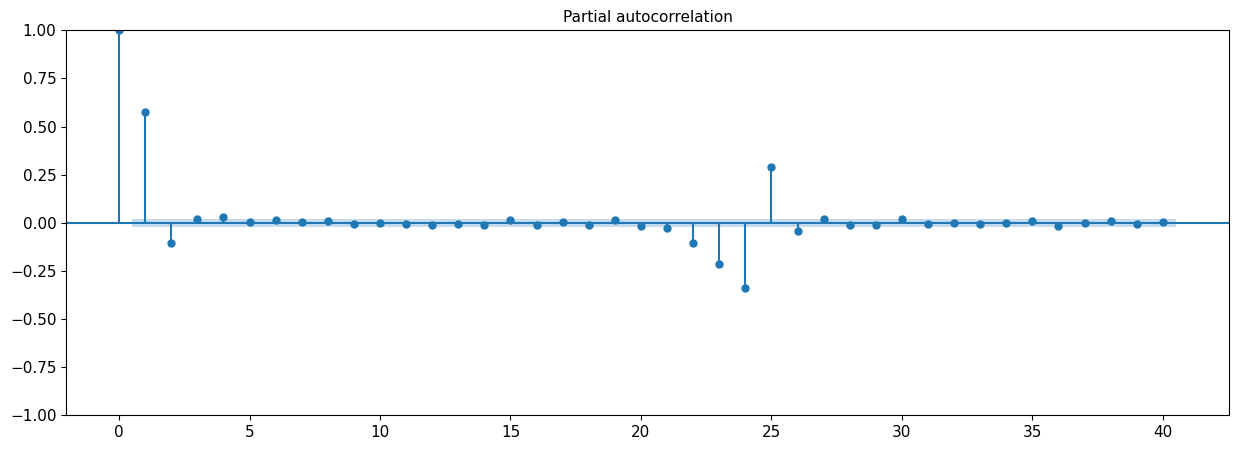

In [120]:
train_series_short_diff = df_train.diff(24).dropna()

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Demand [KWh]', fontsize=11)
plt.xlabel('datetime', fontsize=11)
train_series_short_diff['demand'].plot(figsize=(15,5));

fig = plot_acf(train_series_short_diff['demand'])
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title ('Autocorrelation', fontsize=11)
fig.set_size_inches((10, 5))

fig = plot_pacf(train_series_short_diff['demand'])
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Partial autocorrelation', fontsize=11)
fig.set_size_inches((15, 5))

Use ARMA as autoregressive model and ARMAX as model with exogenous inputs (temperature, hour and price are used). SARIMA should be also tested to see the influence of the seasonal differences.

In [121]:
# try out different orders in the ARMA model to find a good configuration
for i in range(1,3):
    for j in range(1,8,2):
        j=j+1
        model = ARIMA(df_train['demand'],order=(i,0,j), freq='h')
        arma_model = model.fit()

        df_train['model'] = arma_model.predict()
        #df_train[['demand','model']].plot(figsize=(12,8));
        print(f'ARMA({i},0,{j}) MAE = {mean_absolute_error(df_train['demand'],df_train['model'])}')

ARMA(1,0,2) MAE = 0.5143418442908725
ARMA(1,0,4) MAE = 0.51286362103893


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(1,0,6) MAE = 0.502065893921307


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(1,0,8) MAE = 0.5034009812919007
ARMA(2,0,2) MAE = 0.501328438165208
ARMA(2,0,4) MAE = 0.5128679250072496


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(2,0,6) MAE = 0.5029726973092334


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(2,0,8) MAE = 0.5009294289219772


In [122]:
# try out different orders in the ARMAX model to find a good configuration
for i in range(1,3):
    for j in range(1,8,2):
        j=j+1
        model = ARIMA(endog=df_train['demand'], exog=df_train[['temp','hour','price']] ,order=(i,0,j), freq='h')
        armax_model = model.fit()

        df_train['model'] = armax_model.predict()
        #df_train[['demand','model']].plot(figsize=(12,8));
        print(f'ARMAX({i},0,{j}) MAE = {mean_absolute_error(df_train['demand'],df_train['model'])}')

ARMAX(1,0,2) MAE = 0.4986570234665881
ARMAX(1,0,4) MAE = 0.4983092339159237


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMAX(1,0,6) MAE = 0.49799648563000676


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMAX(1,0,8) MAE = 0.4983059806859783
ARMAX(2,0,2) MAE = 0.49856481040685435


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMAX(2,0,4) MAE = 0.49824976491899736


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMAX(2,0,6) MAE = 0.49816144863141026


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMAX(2,0,8) MAE = 0.4979904175284871


In [123]:
# also make model with seasonal difference to see the differences -> needs long computation!
model = SARIMAX(df_train['demand'], order=(2, 0, 2), seasonal_order=(2, 1, 2, 24), freq='h')
sarima_model = model.fit()

df_train['model'] = sarima_model.predict()
#df_train[['demand','model']].plot(figsize=(12,8));
df_train['abs_error'] = np.abs(df_train['demand'] - df_train['model'])
print(f'ARMA MAE = {df_train['abs_error'].mean()}')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34284D+00    |proj g|=  3.61453D-01


 This problem is unconstrained.



At iterate    5    f=  1.23556D+00    |proj g|=  9.07903D-02

At iterate   10    f=  1.23001D+00    |proj g|=  3.59702D-04

At iterate   15    f=  1.23000D+00    |proj g|=  7.24741D-04

At iterate   20    f=  1.22990D+00    |proj g|=  1.03603D-02

At iterate   25    f=  1.22961D+00    |proj g|=  2.82251D-03

At iterate   30    f=  1.22946D+00    |proj g|=  5.48421D-03

At iterate   35    f=  1.22923D+00    |proj g|=  6.59879D-03

At iterate   40    f=  1.22900D+00    |proj g|=  6.62008D-03

At iterate   45    f=  1.22887D+00    |proj g|=  1.09196D-03


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.22877D+00    |proj g|=  2.25139D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57      1     0     0   2.251D-03   1.229D+00
  F =   1.2287739900233356     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARMA MAE = 0.48969574680177425


Make an in-sample prediction for one week and compare it in a plot. The MAEs have been recorded for the prediction of the sample and the part.

In [189]:
# plot predictions of different models for one week

# create models
model = ARIMA(endog=df_train['demand'], exog=df_train[['temp','hour','price']] ,order=(2,0,2), freq='h')
armax_model = model.fit()

model = ARIMA(df_train['demand'],order=(2,0,2), freq='h')
arma_model = model.fit()

model = SARIMAX(df_train['demand'], order=(2, 0, 2), seasonal_order=(2, 1, 2, 24), freq='h')
sarima_model = model.fit()

# make predictions
index_start = df_train.index[-24*7]
index_end = df_train.index[-1]
y_test = df_train[['demand']]
y_test = y_test[index_start:index_end]
X_test = df_train[['temp','hour','price']]
X_test = X_test[index_start:index_end]
armax_result = armax_model.predict(start=index_start, end=index_end, exog=X_test)
arma_result = arma_model.predict(start=index_start, end=index_end)
sarima_result = sarima_model.predict(start=index_start, end=index_end)

# calculate MSE
armax_msa = mean_absolute_error(armax_result, y_test)
arma_msa = mean_absolute_error(arma_result, y_test)
sarima_msa = mean_absolute_error(arma_result, y_test)

print(f'ARMA MSA = {arma_msa}')
print(f'ARMAX MSA = {armax_msa}')
print(f'SARIMA MSA = {sarima_msa}')



/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34284D+00    |proj g|=  3.61453D-01


 This problem is unconstrained.



At iterate    5    f=  1.23556D+00    |proj g|=  9.07903D-02

At iterate   10    f=  1.23001D+00    |proj g|=  3.59702D-04

At iterate   15    f=  1.23000D+00    |proj g|=  7.24741D-04

At iterate   20    f=  1.22990D+00    |proj g|=  1.03603D-02

At iterate   25    f=  1.22961D+00    |proj g|=  2.82251D-03

At iterate   30    f=  1.22946D+00    |proj g|=  5.48421D-03

At iterate   35    f=  1.22923D+00    |proj g|=  6.59879D-03

At iterate   40    f=  1.22900D+00    |proj g|=  6.62008D-03

At iterate   45    f=  1.22887D+00    |proj g|=  1.09196D-03


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.22877D+00    |proj g|=  2.25139D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57      1     0     0   2.251D-03   1.229D+00
  F =   1.2287739900233356     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARMA MSA = 0.39995134176513225
ARMAX MSA = 0.4381001239173224
SARIMA MSA = 0.39995134176513225


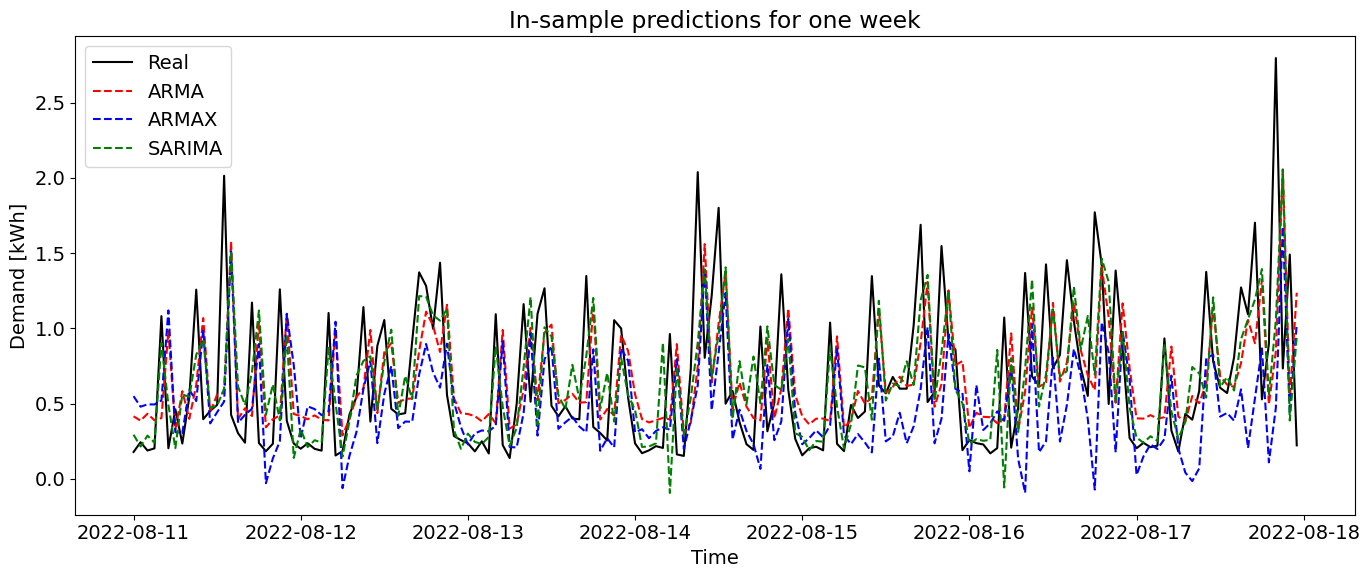

In [195]:
# plot predictions
plt.figure(figsize=(14, 6))
plt.plot(y_test['demand'], label='Real', color='black')
plt.plot(arma_result, label='ARMA', color='red', linestyle='--')
plt.plot(armax_result, label='ARMAX', color='blue', linestyle='--')
plt.plot(sarima_result, label='SARIMA', color='green', linestyle='--')
plt.title('In-sample predictions for one week')
plt.xlabel('Time')
plt.ylabel('Demand [kWh]')
plt.legend()
plt.tight_layout()
plt.savefig("diagrams/prediction_plot.pdf")

# Forecasting

Use out-of-sample daily rolling forecasting with multi-output. ARMA, ARMAX, SARIMA and Seasonal Naive are compared to make forecasts.

In [126]:
df_train = df_train[['demand','temp','hour','price']]
df_test = df_test[['demand','temp','hour','price']]

In [127]:
test_length = len(df_test)
test_days = int(test_length / 24)

train_length = 24 * 30 # number of data points in the training set (number of days that are used)

X_test = df_test[['temp','hour','price']]
y_test = df_test[['demand']]

predictions = [np.array([]), np.array([]), np.array([]), np.array([])]

# make predictions for each day
for day in range(0, test_days):

    # include the previous day from test dataset
    training_set = df_train.tail(train_length-day*24)
    training_set = pd.concat([training_set,df_test.head(day*24)])

    # training vectors
    X_train = training_set[['temp','hour','price']]
    y_train = training_set[['demand']]

    # create models
    model = ARIMA(endog=y_train,order=(2,0,2), freq='h')
    arma_model = model.fit()
    model = ARIMA(endog=y_train,exog=X_train,order=(2,0,2), freq='h')
    armax_model = model.fit()
    model = SARIMAX(y_train, order=(2, 0, 2), seasonal_order=(2, 1, 2, 24), freq='h')
    sarima_model = model.fit()

    # make predictions
    predictions_vector = arma_model.forecast(steps=24)
    predictions[0] = np.append(predictions[0], np.array([predictions_vector]))
    predictions_vector = armax_model.forecast(exog=X_test[day*24:(day+1)*24],steps=24)
    predictions[1] = np.append(predictions[1], np.array([predictions_vector]))

    predictions[2] = np.append(predictions[2], np.array([y_train['demand'].tail(24)]))

    predictions_vector = sarima_model.forecast(steps=24)
    predictions[3] = np.append(predictions[3], np.array([predictions_vector]))


# prepare prediction data frame
df_predictions = pd.DataFrame({
    'arma': predictions[0],
    'armax': predictions[1],
    'seas_naiv': predictions[2],
    'sarima': predictions[3],
})
df_predictions['time'] = df_test.index
df_predictions.set_index('time',inplace=True)
df_predictions = df_predictions.asfreq('h')



/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03626D-01    |proj g|=  6.70476D-01

At iterate    5    f=  6.30716D-01    |proj g|=  9.64478D-02

At iterate   10    f=  6.17030D-01    |proj g|=  8.44751D-03

At iterate   15    f=  6.16575D-01    |proj g|=  4.80600D-03

At iterate   20    f=  6.16359D-01    |proj g|=  1.42079D-03

At iterate   25    f=  6.16077D-01    |proj g|=  9.82776D-03

At iterate   30    f=  6.14588D-01    |proj g|=  2.75815D-02

At iterate   35    f=  6.14268D-01    |proj g|=  6.93876D-03

At iterate   40    f=  6.14183D-01    |proj g|=  5.26211D-04

At iterate   45    f=  6.14140D-01    |proj g|=  1.40977D-02


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.13822D-01    |proj g|=  3.40425D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     67      1     0     0   3.404D-02   6.138D-01
  F =  0.61382245118737211     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09304D-01    |proj g|=  6.42282D-01

At iterate    5    f=  6.38037D-01    |proj g|=  9.05745D-02

At iterate   10    f=  6.21925D-01    |proj g|=  1.00281D-02

At iterate   15    f=  6.20439D-01    |proj g|=  4.42685D-02

At iterate   20    f=  6.19830D-01    |proj g|=  3.18096D-03

At iterate   25    f=  6.19679D-01    |proj g|=  1.22984D-02

At iterate   30    f=  6.19545D-01    |proj g|=  6.52345D-04

At iterate   35    f=  6.19521D-01    |proj g|=  3.37690D-04

At iterate   40    f=  6.19517D-01    |proj g|=  1.66581D-03

At iterate   45    f=  6.19334D-01    |proj g|=  5.15376D-03


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.19157D-01    |proj g|=  2.10828D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     67      1     0     0   2.108D-03   6.192D-01
  F =  0.61915721070473417     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.04420D-01    |proj g|=  6.40955D-01

At iterate    5    f=  6.32771D-01    |proj g|=  1.66809D-01

At iterate   10    f=  6.19794D-01    |proj g|=  4.10563D-03

At iterate   15    f=  6.19654D-01    |proj g|=  1.97935D-03

At iterate   20    f=  6.19129D-01    |proj g|=  1.71433D-02

At iterate   25    f=  6.18431D-01    |proj g|=  1.10065D-02

At iterate   30    f=  6.18108D-01    |proj g|=  1.27108D-02

At iterate   35    f=  6.17996D-01    |proj g|=  4.19529D-03

At iterate   40    f=  6.17580D-01    |proj g|=  1.09378D-03

At iterate   45    f=  6.17554D-01    |proj g|=  2.02318D-03


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.17204D-01    |proj g|=  4.33622D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     67      1     0     0   4.336D-03   6.172D-01
  F =  0.61720390488441690     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98520D-01    |proj g|=  6.67375D-01


 This problem is unconstrained.



At iterate    5    f=  6.25199D-01    |proj g|=  7.29936D-02

At iterate   10    f=  6.10029D-01    |proj g|=  2.27472D-02

At iterate   15    f=  6.09317D-01    |proj g|=  1.08838D-02

At iterate   20    f=  6.09304D-01    |proj g|=  2.19152D-03

At iterate   25    f=  6.09191D-01    |proj g|=  1.93963D-03

At iterate   30    f=  6.09153D-01    |proj g|=  1.97120D-03

At iterate   35    f=  6.09088D-01    |proj g|=  8.08090D-03

At iterate   40    f=  6.08413D-01    |proj g|=  2.24301D-03

At iterate   45    f=  6.07445D-01    |proj g|=  3.49320D-02


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.06257D-01    |proj g|=  2.17040D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63      1     0     0   2.170D-03   6.063D-01
  F =  0.60625727729810419     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03381D-01    |proj g|=  6.68657D-01


 This problem is unconstrained.



At iterate    5    f=  6.28119D-01    |proj g|=  1.53475D-01

At iterate   10    f=  6.16949D-01    |proj g|=  1.36576D-02

At iterate   15    f=  6.16220D-01    |proj g|=  2.45695D-02

At iterate   20    f=  6.15065D-01    |proj g|=  2.88111D-02

At iterate   25    f=  6.14449D-01    |proj g|=  1.13711D-02

At iterate   30    f=  6.13977D-01    |proj g|=  2.42801D-02

At iterate   35    f=  6.13602D-01    |proj g|=  3.02055D-03

At iterate   40    f=  6.13116D-01    |proj g|=  1.21722D-02

At iterate   45    f=  6.12654D-01    |proj g|=  6.81342D-03


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.12263D-01    |proj g|=  9.51538D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     70      1     0     0   9.515D-03   6.123D-01
  F =  0.61226288641286031     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.12866D-01    |proj g|=  6.50165D-01

At iterate    5    f=  6.31939D-01    |proj g|=  5.98733D-02

At iterate   10    f=  6.21087D-01    |proj g|=  4.08761D-03

At iterate   15    f=  6.20984D-01    |proj g|=  5.30250D-03

At iterate   20    f=  6.20245D-01    |proj g|=  2.83431D-02

At iterate   25    f=  6.18345D-01    |proj g|=  1.14194D-02

At iterate   30    f=  6.17967D-01    |proj g|=  6.94368D-03

At iterate   35    f=  6.17787D-01    |proj g|=  1.14305D-03

At iterate   40    f=  6.17190D-01    |proj g|=  3.29785D-02

At iterate   45    f=  6.14823D-01    |proj g|=  1.01143D-02


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.14476D-01    |proj g|=  8.96982D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     60      1     0     0   8.970D-03   6.145D-01
  F =  0.61447567307900397     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07643D-01    |proj g|=  6.38418D-01

At iterate    5    f=  6.18228D-01    |proj g|=  9.77319D-02

At iterate   10    f=  5.97059D-01    |proj g|=  2.90954D-02

At iterate   15    f=  5.96597D-01    |proj g|=  7.29364D-03

At iterate   20    f=  5.96216D-01    |proj g|=  4.84732D-03

At iterate   25    f=  5.96183D-01    |proj g|=  8.75012D-04

At iterate   30    f=  5.95986D-01    |proj g|=  7.71148D-03

At iterate   35    f=  5.95233D-01    |proj g|=  1.36780D-03

At iterate   40    f=  5.95229D-01    |proj g|=  1.18261D-03

At iterate   45    f=  5.95222D-01    |proj g|=  2.02989D-03


/home/niklas/.anaconda3/envs/energy-data-science/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.95153D-01    |proj g|=  8.67251D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     60      1     0     0   8.673D-03   5.952D-01
  F =  0.59515261892744165     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


ARMA MSA = 0.4127858315392678
ARMAX MSA = 0.3950810376606927
Seasonal Naiv MSA = 0.41262499999999996
SARIMA MSA = 0.35167898846134193


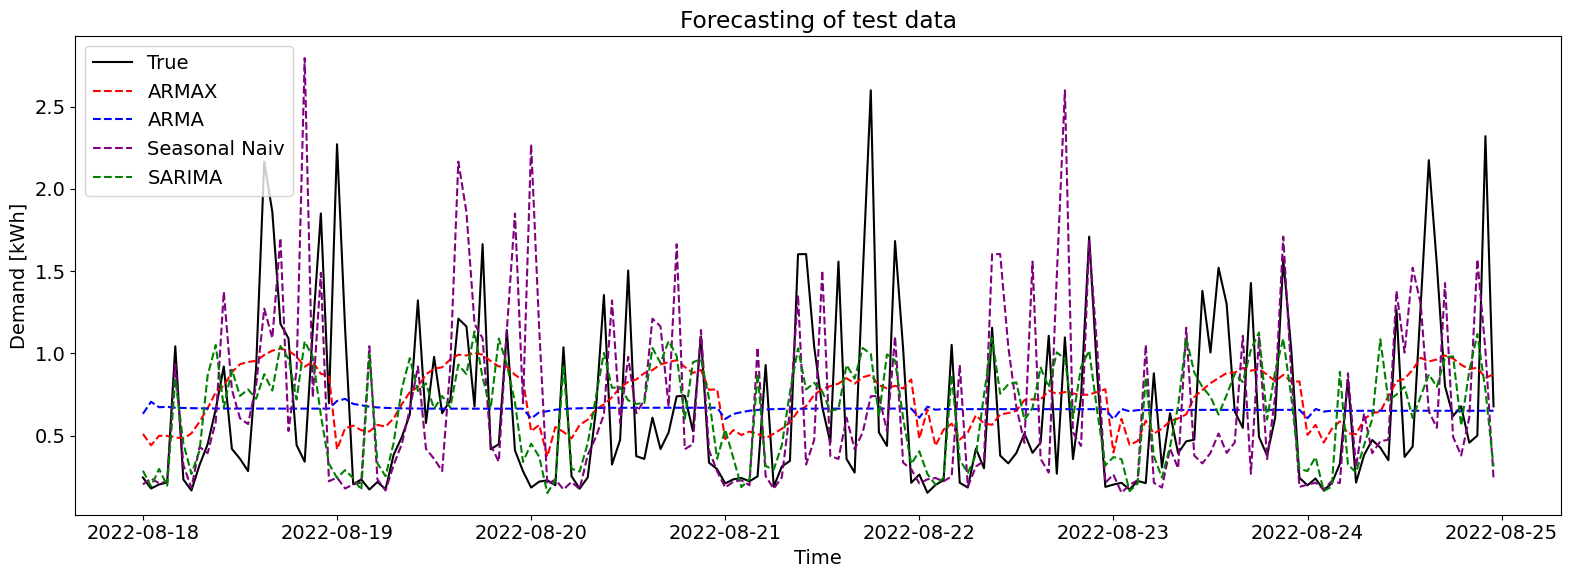

In [194]:
# plot predictions
plt.figure(figsize=(16, 6))
plt.plot(df_test['demand'], label='True', color='black')
plt.plot(df_predictions['armax'], label='ARMAX', color='red', linestyle='--')
plt.plot(df_predictions['arma'], label='ARMA', color='blue', linestyle='--')
plt.plot(df_predictions['seas_naiv'], label='Seasonal Naiv', color='purple', linestyle='--')
plt.plot(df_predictions['sarima'], label='SARIMA', color='green', linestyle='--')
plt.title('Forecasting of test data')
plt.xlabel('Time')
plt.ylabel('Demand [kWh]')
plt.legend()
plt.tight_layout()
plt.savefig("diagrams/forecast_plot.pdf")

# calculate MSEs to compare
armax_msa = mean_absolute_error(df_predictions['armax'], df_test['demand'])
arma_msa = mean_absolute_error(df_predictions['arma'], df_test['demand'])
seas_msa = mean_absolute_error(df_predictions['seas_naiv'], df_test['demand'])
sarima_msa = mean_absolute_error(df_predictions['sarima'], df_test['demand'])

print(f'ARMA MSA = {arma_msa}')
print(f'ARMAX MSA = {armax_msa}')
print(f'Seasonal Naiv MSA = {seas_msa}')
print(f'SARIMA MSA = {sarima_msa}')